In [1]:
import re
import string
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

In [2]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader

In [3]:
!pip install -q transformers

from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification

#from transformers import AdamW

In [4]:
import re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Check if GPU is available for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [5]:
# prompt: MOUNT DRIVE

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [7]:
!unzip /content/drive/MyDrive/COVID_TEXT.zip

Archive:  /content/drive/MyDrive/COVID_TEXT.zip
  inflating: Corona_NLP_test.csv     
  inflating: Corona_NLP_train.csv    


In [8]:
train_df = pd.read_csv("/content/Corona_NLP_test.csv", encoding='latin-1')
test_df = pd.read_csv("/content/Corona_NLP_train.csv", encoding='latin-1')

In [9]:
# ✅ Merge sentiment labels into 3 main classes
sentiment_mapping_3class = {
    "Extremely Negative": "Negative",
    "Negative": "Negative",
    "Neutral": "Neutral",
    "Positive": "Positive",
    "Extremely Positive": "Positive"
}

In [10]:
train_df["Sentiment"] = train_df["Sentiment"].map(sentiment_mapping_3class)
test_df["Sentiment"] = test_df["Sentiment"].map(sentiment_mapping_3class)

# Display dataset shapes
print("✅ Train Data Shape:", train_df.shape)
print("✅ Test Data Shape:", test_df.shape)


✅ Train Data Shape: (3798, 6)
✅ Test Data Shape: (41157, 6)


In [11]:
display(train_df.head())

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


In [12]:
# 📊 Textual summary of sentiment distribution in the training set
print("\n📌 Sentiment Class Distribution (Training Set):")
class_counts = train_df["Sentiment"].value_counts()
print(class_counts)


📌 Sentiment Class Distribution (Training Set):
Sentiment
Negative    1633
Positive    1546
Neutral      619
Name: count, dtype: int64


In [13]:
# 🧮 Also show percentage distribution for more insight
print("\n📌 Sentiment Class Percentage:")
print((class_counts / len(train_df) * 100).round(2).astype(str) + '%')


📌 Sentiment Class Percentage:
Sentiment
Negative     43.0%
Positive    40.71%
Neutral      16.3%
Name: count, dtype: object


<ipython-input-14-7e276f57bcf7>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train_df, x="Sentiment", order=class_counts.index, palette="Set2")


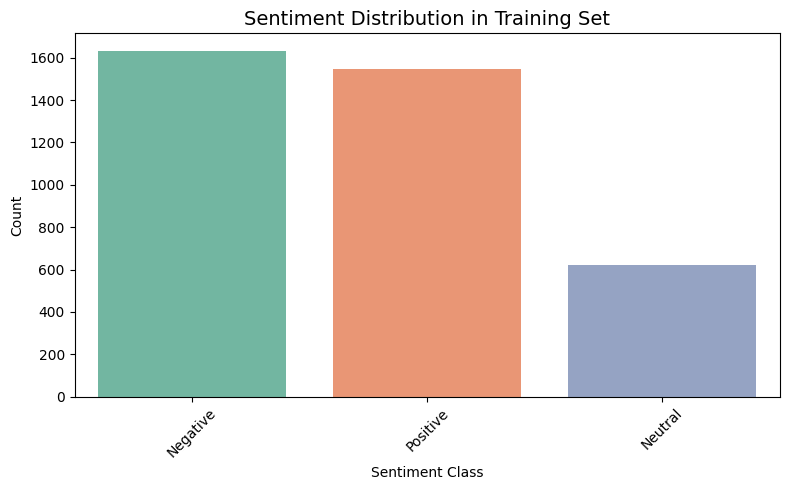

In [14]:
# 📈 Visualize sentiment distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=train_df, x="Sentiment", order=class_counts.index, palette="Set2")
plt.title("Sentiment Distribution in Training Set", fontsize=14)
plt.xticks(rotation=45)
plt.xlabel("Sentiment Class")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [15]:
# Clean text function to remove unwanted characters
def clean_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions
    text = re.sub(r"#\w+", "", text)  # Remove hashtags
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

In [16]:
# Apply text cleaning on both datasets
train_df["clean_text"] = train_df["OriginalTweet"].apply(clean_text)
test_df["clean_text"] = test_df["OriginalTweet"].apply(clean_text)

In [17]:
# Label encoding: map sentiments to numeric values
sentiment_mapping = {
    "Negative": 0,
    "Neutral": 1,
    "Positive": 2
}

train_df["label"] = train_df["Sentiment"].map(sentiment_mapping)
test_df["label"] = test_df["Sentiment"].map(sentiment_mapping)

# Final check: view few preprocessed rows
print("✅ Sample cleaned and labeled data:")
display(train_df[["clean_text", "Sentiment", "label"]].head())

✅ Sample cleaned and labeled data:


,clean_text,Sentiment,label
0,trending new yorkers encounter empty supermark...,Negative,0
1,when i couldnt find hand sanitizer at fred mey...,Positive,2
2,find out how you can protect yourself and love...,Positive,2
3,buying hits city as anxious shoppers stock up ...,Negative,0
4,one week everyone buying baby milk powder the ...,Neutral,1


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [19]:
# 📌 Split the cleaned training data into training and validation sets
# Define features (X) and labels (y)
X = train_df["clean_text"]
y = train_df["label"]

# Split the data: 80% train, 20% validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Display the sizes of each split
print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")

Training set size: 3038
Validation set size: 760


In [20]:
# ---------------------------------------
# 📌 TF-IDF Vectorization
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,         # Maximum number of features to keep
    ngram_range=(1, 2),        # Use unigrams and bigrams
    stop_words='english'       # Remove English stop words
)

# Fit the vectorizer on the training data and transform it
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

# Transform the validation and test sets using the same vectorizer
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(test_df["clean_text"])

Train Logistic Regression Model

In [21]:
# Fit a logistic regression classifier on the TF-IDF features

# Initialize the Logistic Regression model
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

# Train the model on the training data
log_reg.fit(X_train_tfidf, y_train)


# Predict on validation data and print performance metrics

# Predict the validation set
val_preds = log_reg.predict(X_val_tfidf)

# Print accuracy and classification report
from sklearn.metrics import classification_report, accuracy_score

print("Validation Accuracy:", accuracy_score(y_val, val_preds))
print("Classification Report:\n", classification_report(y_val, val_preds))

Validation Accuracy: 0.6328947368421053
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.69      0.70       327
           1       0.41      0.52      0.46       124
           2       0.67      0.62      0.64       309

    accuracy                           0.63       760
   macro avg       0.60      0.61      0.60       760
weighted avg       0.64      0.63      0.64       760



In [22]:
# Load the tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Load the model for multi-class classification (3 labels)
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=3  # We have 3 sentiment classes
)

# ---------------------------------------
# 📌 Set device (GPU if available)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Move model to GPU if available
model.to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [23]:
# ---------------------------------------
# 📌 Define a custom Dataset class for PyTorch

class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        # Tokenize the texts using DistilBERT tokenizer
        self.encodings = tokenizer(texts,
                                   truncation=True,
                                   padding=True,
                                   max_length=max_len,
                                   return_tensors='pt')
        self.labels = labels


    def __getitem__(self, idx):
        # Return a dictionary containing input_ids, attention_mask, and label for each example
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


In [24]:
# ---------------------------------------
# 📌 Set the maximum sequence length

MAX_LEN = 128  # You can increase it to 256 or 512 depending on memory

# ---------------------------------------
# 📌 Prepare the datasets

train_dataset = TweetDataset(X_train.tolist(), y_train.tolist(), tokenizer, MAX_LEN)
val_dataset   = TweetDataset(X_val.tolist(), y_val.tolist(), tokenizer, MAX_LEN)

# ---------------------------------------
# 📌 Create DataLoaders for training and validation

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32)

In [29]:
!pip install transformers --upgrade
import importlib
import transformers
importlib.reload(transformers)  # This will reload the transformers module
from torch.optim import AdamW


In [30]:
# ---------------------------------------
# 📌 Set training parameters

epochs = 5

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.03)

# Loss function
loss_fn = torch.nn.CrossEntropyLoss()

# ---------------------------------------
# 📌 Training loop

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    avg_train_loss = total_loss / len(train_loader)
    print(f"Average training loss: {avg_train_loss:.4f}")

    # ---------------------------------------
    # 📌 Evaluation on validation set
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    print(f"Validation Accuracy: {acc:.4f}")


Epoch 1/5


100%|██████████| 95/95 [22:49<00:00, 14.42s/it]


Average training loss: 0.9197
Validation Accuracy: 0.6882

Epoch 2/5


100%|██████████| 95/95 [22:00<00:00, 13.90s/it]


Average training loss: 0.6236
Validation Accuracy: 0.7684

Epoch 3/5


100%|██████████| 95/95 [22:06<00:00, 13.97s/it]


Average training loss: 0.3963
Validation Accuracy: 0.7711

Epoch 4/5


100%|██████████| 95/95 [22:03<00:00, 13.93s/it]


Average training loss: 0.2376
Validation Accuracy: 0.8079

Epoch 5/5


100%|██████████| 95/95 [22:04<00:00, 13.94s/it]


Average training loss: 0.1548
Validation Accuracy: 0.7882


Classification Report:

              precision    recall  f1-score   support

           0       0.78      0.87      0.82       327
           1       0.71      0.73      0.72       124
           2       0.84      0.72      0.78       309

    accuracy                           0.79       760
   macro avg       0.78      0.78      0.77       760
weighted avg       0.79      0.79      0.79       760



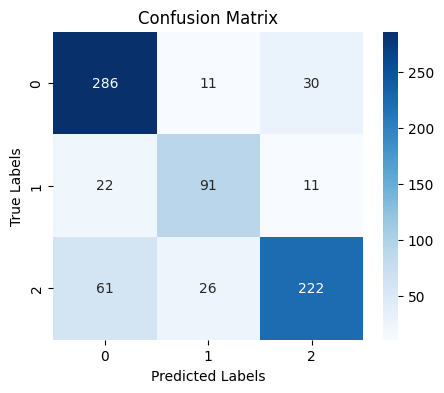

In [31]:
# ---------------------------------------
# 📌 Evaluate on the validation set again (to get metrics)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ---------------------------------------
# 📌 Classification report

print("Classification Report:\n")
print(classification_report(all_labels, all_preds))

# ---------------------------------------
# 📌 Confusion matrix

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [33]:
# Save the model
model.save_pretrained("distilbert_finetuned_model")
tokenizer.save_pretrained("distilbert_finetuned_tokenizer")

print("Model and Tokenizer saved successfully!")

Model and Tokenizer saved successfully!


In [38]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')
tokenizer.fit_on_texts(train_df)  # texts = your list of input strings

sequences = tokenizer.texts_to_sequences(train_df)
X_train_padded = pad_sequences(sequences, maxlen=100, padding='post', truncating='post')


In [39]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)  # labels = list of class labels (strings)
y_train = to_categorical(labels_encoded)


In [40]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential([
    Embedding(input_dim=10000, output_dim=100),  # no input_length needed
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')  # change to 2 if binary classification
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [41]:
history = model.fit(X_train_padded, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.0000e+00 - loss: 1.1264 - val_accuracy: 0.5000 - val_loss: 1.0925
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step - accuracy: 0.5000 - loss: 1.0997 - val_accuracy: 0.5000 - val_loss: 1.0965
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6667 - loss: 1.0849 - val_accuracy: 0.5000 - val_loss: 1.0999
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.5000 - loss: 1.0808 - val_accuracy: 0.5000 - val_loss: 1.1039
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step - accuracy: 0.8333 - loss: 1.0502 - val_accuracy: 0.5000 - val_loss: 1.1108
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - accuracy: 0.5000 - loss: 1.0445 - val_accuracy: 0.5000 - val_loss: 1.1183
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - accuracy: 0.8333 - loss: 1.0024 - val_accuracy: 0.5000 - val_loss: 1.1249
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step - accuracy: 0.6667 - loss: 0.9905 - val_accuracy: 0.5000 - val_loss

In [47]:
print(train_data.columns)
print(test_data.columns)


Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')
Index(['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet',
       'Sentiment'],
      dtype='object')


In [48]:
# 1. Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# 2. Load and Prepare Data from Separate Train and Test Files
train_data = pd.read_csv("/content/Corona_NLP_train.csv", encoding='latin1')  # or 'ISO-8859-1'
test_data = pd.read_csv("/content/Corona_NLP_test.csv", encoding='latin1')

texts = train_data['OriginalTweet'].astype(str).tolist() + test_data['OriginalTweet'].astype(str).tolist()
labels = train_data['Sentiment'].astype(str).tolist() + test_data['Sentiment'].astype(str).tolist()


# 3. Text Preprocessing
vocab_size = 10000
max_length = 100
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# 4. Encode Labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(labels)
y_categorical = to_categorical(y_encoded)

# 5. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# 6. LSTM Model
lstm_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=100),
    LSTM(64),
    Dropout(0.5),
    Dense(32, activation='relu'),
    Dense(y_categorical.shape[1], activation='softmax')
])

lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.fit(X_train, y_train, epochs=5, batch_size=32, validation_split=0.1)

# Evaluate LSTM
lstm_preds = lstm_model.predict(X_test)
lstm_preds_classes = np.argmax(lstm_preds, axis=1)
y_true = np.argmax(y_test, axis=1)
print("LSTM Classification Report:\n", classification_report(y_true, lstm_preds_classes))
print("LSTM Accuracy:", accuracy_score(y_true, lstm_preds_classes))

# 7. Traditional ML models use flattened input
y_flat = y_encoded
y_train_flat, y_test_flat = train_test_split(y_flat, test_size=0.2, random_state=42)

# Gradient Boosting
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train_flat)
gb_preds = gb_model.predict(X_test)
print("\nGradient Boosting Classification Report:\n", classification_report(y_true, gb_preds))
print("Gradient Boosting Accuracy:", accuracy_score(y_true, gb_preds))

# XGBoost
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train_flat)
xgb_preds = xgb_model.predict(X_test)
print("\nXGBoost Classification Report:\n", classification_report(y_true, xgb_preds))
print("XGBoost Accuracy:", accuracy_score(y_true, xgb_preds))

# LightGBM
lgbm_model = LGBMClassifier()
lgbm_model.fit(X_train, y_train_flat)
lgbm_preds = lgbm_model.predict(X_test)
print("\nLightGBM Classification Report:\n", classification_report(y_true, lgbm_preds))
print("LightGBM Accuracy:", accuracy_score(y_true, lgbm_preds))

# 8. Comparative Summary
models = ['LSTM', 'Gradient Boosting', 'XGBoost', 'LightGBM']
accuracies = [
    accuracy_score(y_true, lstm_preds_classes),
    accuracy_score(y_true, gb_preds),
    accuracy_score(y_true, xgb_preds),
    accuracy_score(y_true, lgbm_preds)
]

comparison_df = pd.DataFrame({'Model': models, 'Accuracy': accuracies})
print("\nComparative Model Accuracy:\n", comparison_df)

Epoch 1/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 75s 70ms/step - accuracy: 0.2727 - loss: 1.5807 - val_accuracy: 0.2713 - val_loss: 1.5813
Epoch 2/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 75s 74ms/step - accuracy: 0.2735 - loss: 1.5774 - val_accuracy: 0.2713 - val_loss: 1.5815
Epoch 3/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 80s 72ms/step - accuracy: 0.2767 - loss: 1.5765 - val_accuracy: 0.2713 - val_loss: 1.5823
Epoch 4/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 81s 71ms/step - accuracy: 0.2749 - loss: 1.5762 - val_accuracy: 0.2713 - val_loss: 1.5822
Epoch 5/5
1012/1012 ━━━━━━━━━━━━━━━━━━━━ 82s 71ms/step - accuracy: 0.2788 - loss: 1.5739 - val_accuracy: 0.2713 - val_loss: 1.5814
281/281 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step
LSTM Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00      1189
           1       0.00      0.00      0.00      1457
           2       0.00      0.00      0.00      2204
           3       0.00      0.00      0.00      1681
   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Gradient Boosting Classification Report:
               precision    recall  f1-score   support

           0       0.23      0.03      0.05      1189
           1       0.23      0.04      0.07      1457
           2       0.27      0.13      0.18      2204
           3       0.42      0.45      0.43      1681
           4       0.29      0.67      0.40      2460

    accuracy                           0.31      8991
   macro avg       0.29      0.26      0.23      8991
weighted avg       0.29      0.31      0.25      8991

Gradient Boosting Accuracy: 0.3088644199755311


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:36:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.24      0.10      0.14      1189
           1       0.28      0.16      0.21      1457
           2       0.29      0.30      0.29      2204
           3       0.41      0.43      0.42      1681
           4       0.30      0.44      0.35      2460

    accuracy                           0.31      8991
   macro avg       0.30      0.29      0.28      8991
weighted avg       0.31      0.31      0.30      8991

XGBoost Accuracy: 0.31353575798020245


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13863
[LightGBM] [Info] Number of data points in the train set: 35964, number of used features: 62
[LightGBM] [Info] Start training from score -1.996554
[LightGBM] [Info] Start training from score -1.830540
[LightGBM] [Info] Start training from score -1.413008
[LightGBM] [Info] Start training from score -1.687751
[LightGBM] [Info] Start training from score -1.289075


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(



LightGBM Classification Report:
               precision    recall  f1-score   support

           0       0.25      0.06      0.10      1189
           1       0.25      0.11      0.15      1457
           2       0.26      0.20      0.23      2204
           3       0.42      0.45      0.44      1681
           4       0.29      0.54      0.37      2460

    accuracy                           0.31      8991
   macro avg       0.29      0.27      0.26      8991
weighted avg       0.29      0.31      0.28      8991

LightGBM Accuracy: 0.3054165276387499

Comparative Model Accuracy:
                Model  Accuracy
0               LSTM  0.273607
1  Gradient Boosting  0.308864
2            XGBoost  0.313536
3           LightGBM  0.305417
